# Data Analysis for Amazon Sports and Outdoors reviews datasets
###### Piotr Stachowicz, Jakub Malczak

### Config

In [1]:
FILE = "Amazon_Sports_and_Outdoors"
CLEAN = True

### 1. Dependencies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.json as pjs
import json
import seaborn as sns

In [3]:
def clean(inp_path: str, out_path: str, columns: list[str]) -> None:
    with open(inp_path, 'r') as f, open(out_path, 'w+') as w:
        for row in f:
            entry = json.loads(row)

            new_entry = dict()

            for col in columns:
                try:
                    new_entry[col] = entry[col]
                except Exception:
                    print(f'There was an error while creating new entry! Probably {col} does not exist in input file!')

            w.write(json.dumps(new_entry) + '\n')

def convert_metadata(inp_path: str, out_path: str):
    with open(inp_path, 'r') as f, open(out_path, 'w+') as w:
            for line in f:
                data = json.loads(line)
                asin = data['parent_asin']
                categories = data.get('categories', [])

                if not categories:
                    continue

                category = categories[-1][-1] if isinstance(categories[-1], list) else categories[-1]
                
                new_entry = {
                    'parent_asin': asin,
                    'category': category
                }

                w.write(json.dumps(new_entry) + '\n')

### 2. Dataset loading

In [4]:
if CLEAN:
    dataset = f"./{FILE}.jsonl"
    meta = f"./meta_{FILE}.jsonl"

    clean(
        dataset, 
        f"./{FILE}_cleaned.jsonl", 
        ['rating', 'asin', 'parent_asin', 'user_id', 'timestamp', 'verified_purchase']
    )
    convert_metadata(meta, f"./meta_{FILE}_cleaned.jsonl")

dataset = f"./{FILE}_cleaned.jsonl"
meta = f"./meta_{FILE}_cleaned.jsonl"

try:
    df: pd.DataFrame = pjs.read_json(dataset, parse_options=pjs.ParseOptions()).to_pandas()
except Exception:
    raise Exception(f"Error while loading file: {dataset}")

### 3. Fun statistics

#### 3.1 Data structure

In [5]:
df.head()

,rating,asin,parent_asin,user_id,timestamp,verified_purchase
0,5.0,B07F3BDT8T,B0BGFR76CF,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1677321053520,True
1,5.0,B00NXQLFQQ,B00NXQLFQQ,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1523093771676,True
2,5.0,B08SVPR266,B0957WLR63,AGGZ357AO26RQZVRLGU4D4N52DZQ,1653526919105,True
3,5.0,B00IET8S80,B00IET8S80,AGGZ357AO26RQZVRLGU4D4N52DZQ,1627330911189,True
4,5.0,B00DV0MKUY,B01C2SW7XA,AGGZ357AO26RQZVRLGU4D4N52DZQ,1617831811976,True


In [6]:
df.keys()

Index(['rating', 'asin', 'parent_asin', 'user_id', 'timestamp',
       'verified_purchase'],
      dtype='object')

#### 3.2 Unique Users & Products

In [7]:
unique_users = df['user_id'].nunique()
unique_products = df['asin'].nunique()

print(f"Number of unique users: {unique_users}")
print(f"Number of unique products: {unique_products}")

Number of unique users: 10331141
Number of unique products: 2240698


#### 3.3 Average Rating

In [8]:
ratings = df.shape[0]
avg_rating = df['rating'].sum() / ratings

print(f"Average rating is: {avg_rating}")

Average rating is: 4.218416834352547


In [9]:
print(ratings)

19595170


#### 3.4 Average Reviews per User

In [10]:
avg_user_reviews = ratings / unique_users

print(f"Average reviews per user: {avg_user_reviews}")

Average reviews per user: 1.896709182461066


#### 3.5 Average Reviews per Product

In [11]:
avg_product_reviews = ratings / unique_products

print(f"Average reviews per product: {avg_product_reviews}")

Average reviews per product: 8.745118708545284


#### 3.6 Number of reviews per user

In [12]:
user_counts = df.groupby("user_id").size().reset_index(name="review_count")

##### 3.6.1 Top 10 reviewers

In [13]:
user_counts.sort_values('review_count', ascending=False).head(10)

,user_id,review_count
5259853,AG375WAXLZ7PIOQKIQ6KQB4J3JVQ,858
9693165,AHS5OQLOPMP2YCRIWK3W6WDJ7BLQ,557
7328959,AGUTZC4GHLTGYHA3KBEDRF6MHB6A,471
8080629,AH665SQ6SQF6DXAGYIQFCX76LALA,442
9053703,AHKADS7LVZVUGZWPOYIDMZMNPJRA,417
1167338,AEIIRIHLIYKQGI7ZOCIJTRDF5NPQ,412
7028571,AGR4TFBURFNDIPLCMOW6GFEFPBSA,409
7807072,AH2RP3F6O7WJY2C7RDK7RGZZYOEQ,406
9165502,AHLMM7DZIQ2RUHUY33SC7X7U7XLQ,398
7747528,AGZZXSMMS4WRHHJRBUJZI4FZDHKQ,383


##### 3.6.2 Distribution plot

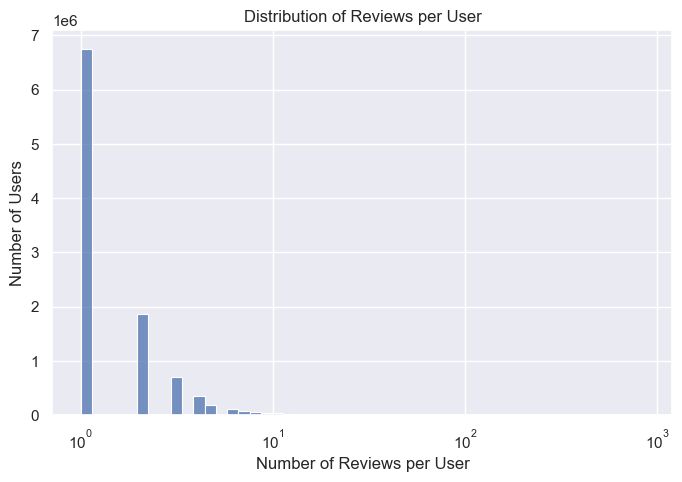

In [14]:
plt.figure(num=0, figsize=(8, 5))
sns.set_theme(style="darkgrid")

sns.histplot(
    user_counts['review_count'], 
    bins=50, log_scale=True
)

plt.xlabel("Number of Reviews per User")
plt.ylabel("Number of Users")
plt.title("Distribution of Reviews per User")

plt.show()

#### 3.7 User x Product Matrix Sparsity

In [15]:
matrix_size = unique_users * unique_products
matrix_sparsity = 1.0 - (ratings / matrix_size)

print(f"Matrix sparsity of dataset: {matrix_sparsity}%")

Matrix sparsity of dataset: 0.9999991535185989%


#### 3.8 Number of reviews per product

In [17]:
product_counts = df.groupby(["asin"]).size().reset_index(name="review_count")

##### 3.8.1 Top 10 reviewed products

In [18]:
product_counts.sort_values(by="review_count", ascending=False).head(10)

,asin,review_count
561495,B00FAW4O0A,20031
921409,B01AVDVHTI,14766
897600,B018L2WM86,14029
702469,B00NPLSZF8,13541
132918,B001T7QJ9O,13192
488356,B00BGO0Q9O,12744
1425496,B07FP4Z3RZ,11929
693205,B00N2BW2PK,11231
870129,B0160HYB8S,10605
693206,B00N2BW638,10340


##### 3.8.2 Distribution plot

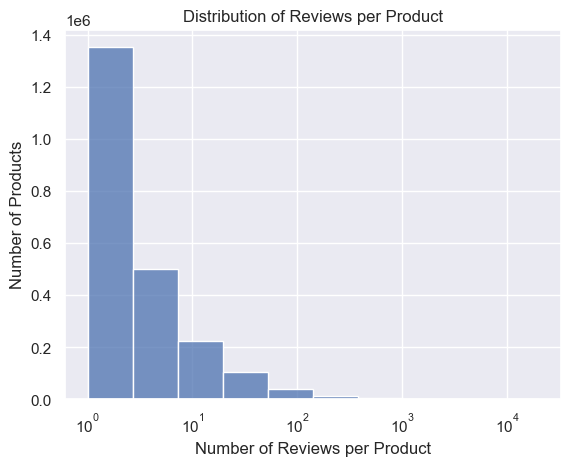

In [21]:
plt.figure(num=1)
sns.set_theme(style="darkgrid")

sns.histplot(
    data=product_counts['review_count'], 
    bins=10,
    log_scale=True
)

plt.xlabel("Number of Reviews per Product")
plt.ylabel("Number of Products")
plt.title("Distribution of Reviews per Product")

plt.show()

#### 3.9 Product lifespan analysis

In [22]:
lifespan_df = df.groupby(by='asin')['timestamp'].agg(['min', 'max'])
lifespan_df['max'] = pd.to_datetime(lifespan_df['max'], unit='ms')
lifespan_df['min'] = pd.to_datetime(lifespan_df['min'], unit='ms')

lifespan_df['lifespan'] = lifespan_df['max'] - lifespan_df['min']
lifespan_df['lifespan'] = lifespan_df['lifespan'].dt.days

In [23]:
lifespan_df = lifespan_df[lifespan_df['lifespan'] != 0]

lifespan_df.head()

,min,max,lifespan
asin,,,
0201397544,2017-05-31 02:33:39.000,2019-05-05 16:09:21.744,704
030827962X,2015-12-29 11:33:20.000,2017-07-07 17:41:47.032,556
0316287229,2015-06-21 19:13:53.000,2017-09-18 21:06:05.844,820
0318279622,2015-12-02 18:03:53.000,2018-02-26 21:33:35.109,817
0578403684,2018-11-24 23:04:18.920,2020-07-11 19:44:32.713,594


##### 3.9.1 Product lifespan distribution

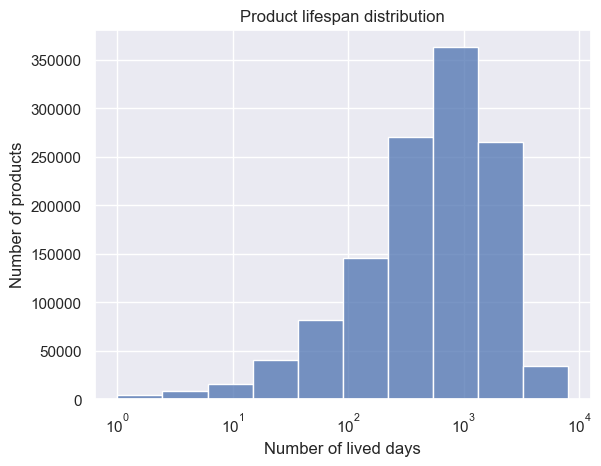

In [24]:
plt.figure(num=3)
sns.histplot(
    lifespan_df['lifespan'],
    log_scale=True,
    bins=10
)
plt.xlabel("Number of lived days")
plt.ylabel("Number of products")
plt.title("Product lifespan distribution")
plt.show()

##### 3.9.2 Seasonality of products

In [25]:
seasonality_df = df.copy()
seasonality_df['timestamp'] = pd.to_datetime(seasonality_df['timestamp'], unit='ms')

In [26]:
seasonality_df = seasonality_df[seasonality_df['verified_purchase'] == True]

In [27]:
seasonality_df.head()

,rating,asin,parent_asin,user_id,timestamp,verified_purchase
0,5.0,B07F3BDT8T,B0BGFR76CF,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2023-02-25 10:30:53.520,True
1,5.0,B00NXQLFQQ,B00NXQLFQQ,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2018-04-07 09:36:11.676,True
2,5.0,B08SVPR266,B0957WLR63,AGGZ357AO26RQZVRLGU4D4N52DZQ,2022-05-26 01:01:59.105,True
3,5.0,B00IET8S80,B00IET8S80,AGGZ357AO26RQZVRLGU4D4N52DZQ,2021-07-26 20:21:51.189,True
4,5.0,B00DV0MKUY,B01C2SW7XA,AGGZ357AO26RQZVRLGU4D4N52DZQ,2021-04-07 21:43:31.976,True


In [28]:
seasonality_df.set_index('timestamp', inplace=True)

In [29]:
monthly_transaction_count = seasonality_df['verified_purchase'].resample('MS').count().reset_index(name="purchase_count")
monthly_transaction_count.head(10)

,timestamp,purchase_count
0,2000-05-01,1
1,2000-06-01,0
2,2000-07-01,0
3,2000-08-01,0
4,2000-09-01,0
5,2000-10-01,0
6,2000-11-01,0
7,2000-12-01,0
8,2001-01-01,1
9,2001-02-01,0


##### 3.9.3 Top 20 highest selling months

In [30]:
monthly_transaction_count.sort_values(by='purchase_count', ascending=False).head(20)

,timestamp,purchase_count
230,2019-07-01,273938
236,2020-01-01,271835
235,2019-12-01,261641
242,2020-07-01,254896
243,2020-08-01,253088
254,2021-07-01,249802
250,2021-03-01,239029
251,2021-04-01,238947
253,2021-06-01,238019
231,2019-08-01,230320


##### 3.9.4 Time series

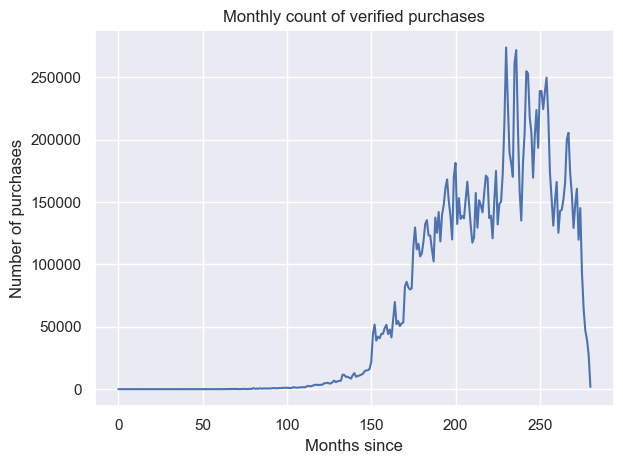

In [31]:
plt.figure(num=4)
monthly_transaction_count['purchase_count'].plot(title="Monthly count of verified purchases")
plt.xlabel('Months since')
plt.ylabel('Number of purchases')
plt.tight_layout()
plt.grid(True)
plt.show()

In [32]:
month_subseries_count = monthly_transaction_count.copy()
month_subseries_count['month'] = month_subseries_count['timestamp'].dt.month

foo = month_subseries_count.groupby(by='month')['purchase_count'].sum().reset_index(name='purchase_count')
foo.head(12)

,month,purchase_count
0,1,1751520
1,2,1393368
2,3,1517753
3,4,1384764
4,5,1445163
5,6,1558671
6,7,1799896
7,8,1746837
8,9,1477541
9,10,1389985


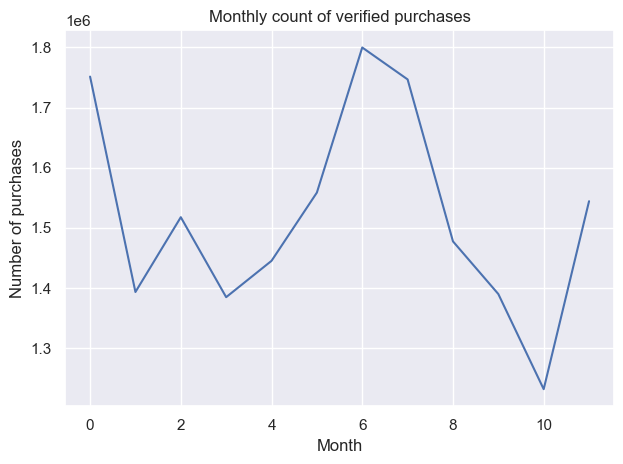

In [33]:
plt.figure(num=5)
foo['purchase_count'].plot(title="Monthly count of verified purchases")
plt.xlabel('Month')
plt.ylabel('Number of purchases')
plt.tight_layout()
plt.grid(True)
plt.show()

#### 3.10 Rating distribution

In [34]:
rating_counts = df['rating'].value_counts().sort_index()
rating_counts.head()

rating
1.0     1836990
2.0      933101
3.0     1324911
4.0     2518170
5.0    12981998
Name: count, dtype: int64

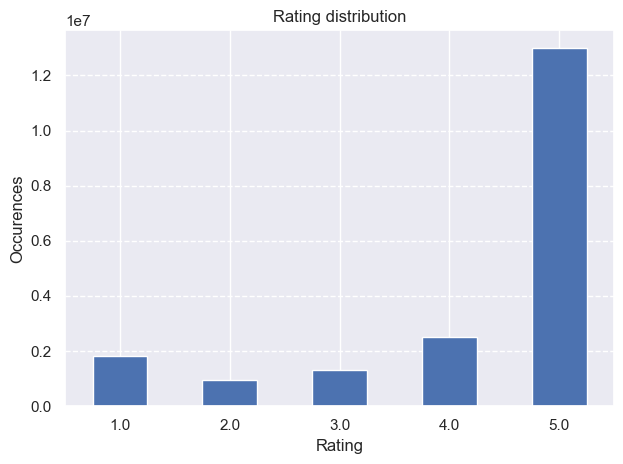

In [35]:
plt.figure(num=6)
rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Occurences')
plt.title('Rating distribution')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

#### 3.11 Subclasses

In [36]:
try:
    df2: pd.DataFrame = pjs.read_json(meta, parse_options=pjs.ParseOptions()).to_pandas()
except Exception:
    raise Exception(f"Error while loading file: {meta}")

In [37]:
df2.head()

,parent_asin,category
0,B01HDXC8AG,Wheels
1,B07R5BQ4YD,Dry Bags
2,B003K8GZ7G,Earrings
3,B08GC4GBWB,Outdoor Skates
4,B07BYV947H,Golf Bag Towels


In [38]:
df2 = pd.merge(df, df2, on='parent_asin', how='left')

In [39]:
df2.head()

,rating,asin,parent_asin,user_id,timestamp,verified_purchase,category
0,5.0,B07F3BDT8T,B0BGFR76CF,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1677321053520,True,Camping & Hiking
1,5.0,B00NXQLFQQ,B00NXQLFQQ,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1523093771676,True,Sports Water Bottles
2,5.0,B08SVPR266,B0957WLR63,AGGZ357AO26RQZVRLGU4D4N52DZQ,1653526919105,True,Saddle Pads
3,5.0,B00IET8S80,B00IET8S80,AGGZ357AO26RQZVRLGU4D4N52DZQ,1627330911189,True,Sports & Outdoors Low Return Rate Alert 1
4,5.0,B00DV0MKUY,B01C2SW7XA,AGGZ357AO26RQZVRLGU4D4N52DZQ,1617831811976,True,Girths


In [40]:
subcategories_df = df2.dropna(subset=['category'])
unique_parent_asins_in_subcategory = subcategories_df[['parent_asin', 'category']].drop_duplicates()
product_count_by_subcategory = unique_parent_asins_in_subcategory.groupby('category')['parent_asin'].count().sort_values(ascending=False)

In [41]:
product_count_by_subcategory.head()

category
T-Shirts                 49701
Decals                   29186
Sports Water Bottles     28334
Baseball Caps            26543
Sweatshirts & Hoodies    20711
Name: parent_asin, dtype: int64

In [42]:
top_n_subcategories = product_count_by_subcategory.head(20)
others_count = product_count_by_subcategory.iloc[20:].sum()

if others_count > 0:
    top_n_subcategories['Other'] = others_count

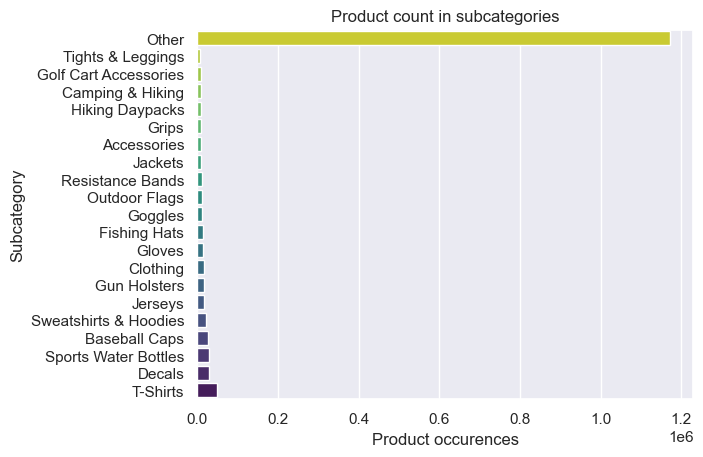

In [43]:
barplot = sns.barplot(x=top_n_subcategories.values, y=top_n_subcategories.index, palette="viridis", hue=top_n_subcategories.index, dodge=False, legend=False)
plt.xlabel('Product occurences')
plt.ylabel('Subcategory')
plt.title(f'Product count in subcategories')
plt.gca().invert_yaxis()

### 4.0 Check photo availability

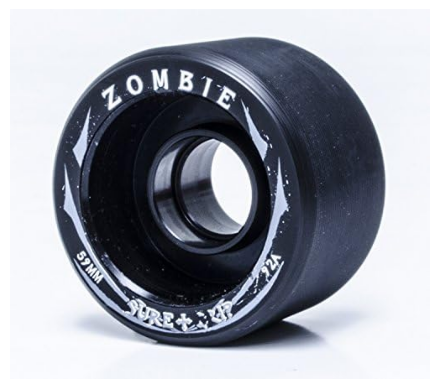

In [44]:
import requests
from PIL import Image
from io import BytesIO

with open(f'./meta_{FILE}.jsonl', 'r') as f:
    data = f.readline()
    first = json.loads(data)

    image_url = first['images'][0]['large']

    response = requests.get(image_url, stream=True)
    response.raise_for_status()

    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
